In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

/tmp/ipykernel_15514/2236454491.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)

In [ ]:
class AdaIN(nn.Module):
    def __init__(self, style_dim, num_features):
        super().__init__()
        self.norm = nn.InstanceNorm2d(num_features)
        self.fc = nn.Linear(style_dim, num_features*2)

    def forward(self, x, style):
        h = self.fc(style)                          # (B, D) -> (B, C*2)
        gamma, beta = h.chunk(2, dim=1)             # (B, C), (B, C)

        gamma = gamma.unsqueeze(-1).unsqueeze(-1)   # (B, C, 1, 1)
        beta = beta.unsqueeze(-1).unsqueeze(-1)     # (B, C, 1, 1)

        out = self.norm(x)
        out = gamma * out + beta
        return out


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, style_dim, dropout):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1)
        self.GELU = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, style):
        x = self.conv(x)            # Préserve la taille de l'image
        x = self.GELU(x)
        x = self.dropout(x)
        return x


class Encoder(nn.Module):
    def __init__(self, in_channels, style_dim, dropout):
        super().__init__()
        self.block1 = EncoderBlock(in_channels, 32, style_dim, dropout)
        self.block2 = EncoderBlock(32, 64, style_dim, dropout)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x, style):
        x = self.block1(x, style)   # (B, 1, 28, 28) -> (B, 32, 28, 28)
        x = self.pool(x)            # (B, 32, 28, 28) -> (B, 32, 14, 14)
        x = self.block2(x, style)   # (B, 32, 14, 14) -> (B, 64, 14, 14)
        x = self.pool(x)            # (B, 64, 7, 7) -> (B, 64, 7, 7)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, style_dim, dropout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)
        self.GELU = nn.GELU()
        self.adain = AdaIN(style_dim, out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, style):
        x = self.conv(x)            # Double la taille de l'image
        x = self.GELU(x)
        x = self.adain(x, style)
        x = self.dropout(x)
        return x


class Decoder(nn.Module):
    def __init__(self, out_channels, style_dim, dropout):
        super().__init__()
        self.block1 = DecoderBlock(64, 32, style_dim, dropout)
        self.block2 = DecoderBlock(32, 16, style_dim, dropout)
        self.conv = nn.ConvTranspose2d(16, out_channels, 3, stride=1, padding=1)

    def forward(self, x, style):
        x = self.block1(x, style)   # (B, 64, 7, 7) -> (B, 32, 14, 14)
        x = self.block2(x, style)   # (B, 32, 14, 14) -> (B, 16, 28, 28)
        x = self.conv(x)            # (B, 16, 28, 28) -> (B, 1, 28, 28)
        return x


class CVAEGenerator(nn.Module):
    """Générateur (cVAE) = Encodeur + Décodeur conditionnel."""
    def __init__(self, latent_dim=32, label_embed_dim=32, num_classes=10, dropout=0.1):
        super().__init__()
        self.latent_dim = latent_dim
        self.label_embed_dim = label_embed_dim
        self.num_classes = num_classes

        self.label_embedding = nn.Embedding(num_classes, label_embed_dim)

        # Encodeur
        self.encoder = Encoder(1, label_embed_dim, dropout=dropout)
        self.encoder_projection_mu = nn.Linear(64*7*7, latent_dim)
        self.encoder_projection_logvar = nn.Linear(64*7*7, latent_dim)
        self.flatten = nn.Flatten()

        # Décodeur
        self.decoder_projection = nn.Linear(latent_dim + label_embed_dim, 64*7*7)
        self.decoder = Decoder(1, label_embed_dim, dropout=dropout)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, label):
        label_embed = self.label_embedding(label)
        x = self.encoder(x, label_embed)
        x = self.flatten(x)

        mu = self.encoder_projection_mu(x)
        logvar = self.encoder_projection_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, label):
        label_embed = self.label_embedding(label)
        x = torch.cat([z, label_embed], dim=1)
        x = self.decoder_projection(x)
        x = x.view(-1, 64, 7, 7)

        x = self.decoder(x, label_embed)
        return self.sigmoid(x)

    def forward(self, x, label):
        mu, logvar = self.encode(x, label)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, label), mu, logvar


generator = CVAEGenerator(latent_dim=32, label_embed_dim=32, num_classes=10, dropout=0.1).to(device)
sum(p.numel() for p in generator.parameters() if p.requires_grad)

468065

In [4]:
class ConditionalDiscriminator(nn.Module):
	def __init__(self, in_channels=1, label_embed_dim=32, dropout=0.1):
		super().__init__()
		self.label_embedding = nn.Embedding(10, label_embed_dim)
		self.conv1 = nn.Conv2d(in_channels, 32, 4, stride=2, padding=1)
		self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
		self.adain1 = AdaIN(label_embed_dim, 32)
		self.adain2 = AdaIN(label_embed_dim, 64)
		self.fc = nn.Linear(64*7*7, 1)
		
		self.flatten = nn.Flatten()
		self.GELU = nn.GELU()
		self.dropout = nn.Dropout(dropout)

	def extract_features(self, x, label):
		label_embed = self.label_embedding(label)
		x = self.conv1(x)				# (B, 1, 28, 28) -> (B, 32, 14, 14)
		x = self.GELU(x)
		x = self.adain1(x, label_embed)
		x = self.dropout(x)
		x = self.conv2(x)				# (B, 32, 14, 14) -> (B, 64, 7, 7)
		x = self.GELU(x)
		x = self.adain2(x, label_embed)
		x = self.dropout(x)
		x = self.flatten(x)				# (B, 64, 7, 7) -> (B, 64*7*7)
		return x

	def forward(self, x, label):
		x = self.extract_features(x, label)
		x = self.fc(x)
		return x

discriminator = ConditionalDiscriminator(in_channels=1, label_embed_dim=32, dropout=0.1).to(device)
sum(p.numel() for p in discriminator.parameters() if p.requires_grad)

43169

In [5]:
def vae_reconstruction_loss(x_recon, x):
    """Calcul la différence entre l'image originale et l'image reconstruite."""
    return F.binary_cross_entropy(x_recon, x, reduction='mean')

def vae_kl_divergence(mu, logvar):
    """Calcul la divergence KL entre la distribution latente et une normale."""
    return 0.5 * torch.mean(mu**2 + torch.exp(logvar) - logvar - 1)

def feature_matching_loss(discriminator, real_imgs, fake_imgs, labels):
    """Calcul la perte de feature matching."""
    real_features = discriminator.extract_features(real_imgs, labels)
    fake_features = discriminator.extract_features(fake_imgs, labels)
    return F.mse_loss(real_features, fake_features)

bce_loss = nn.BCEWithLogitsLoss()	# perte du discriminateur

In [6]:
optimizer_G = torch.optim.AdamW(generator.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer_D = torch.optim.AdamW(discriminator.parameters(), lr=5e-5, weight_decay=1e-4)

In [7]:
num_epochs = 20

recon_lambda = 1.0
kl_lambda = 1.0
feat_lambda = 0.25
adv_lambda = 0.025

label_smoothing = 0.1

for epoch in range(num_epochs):
	loss_recon = 0.0
	loss_kl = 0.0
	loss_feat = 0.0
	loss_adv = 0.0

	for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
		images = images.to(device)
		labels = labels.to(device)

		# Entraîner le générateur
		generator.train()
		discriminator.eval()

		optimizer_G.zero_grad()

		for p in discriminator.parameters():
			p.requires_grad = False

		# 1) Reconstruction de l'image
		images_pred, mu, logvar = generator(images, labels)
		recon_loss = vae_reconstruction_loss(images_pred, images)

		# 2) Divergence KL
		kl_loss = vae_kl_divergence(mu, logvar)

		# 3) Perte de feature matching
		feat_loss = feature_matching_loss(discriminator, images, images_pred, labels)

		# 4) Adversarial loss
		disc_preds = discriminator(images_pred, labels)
		adv_loss = bce_loss(disc_preds, torch.ones_like(disc_preds))

		# Perte totale
		loss = (
			recon_lambda * recon_loss +
			kl_lambda * kl_loss +
			feat_lambda * feat_loss +
			adv_lambda * adv_loss
		)
		loss.backward()
		nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
		optimizer_G.step()

		# Entraîner le discriminateur
		generator.eval()
		discriminator.train()

		optimizer_D.zero_grad()

		for p in discriminator.parameters():
			p.requires_grad = True

		# 1) prédiction du discriminateur
		real_preds = discriminator(images, labels)
		fake_preds = discriminator(images_pred.detach(), labels)

		# 2) Perte totale
		true_labels = torch.cat([(1 - label_smoothing) * torch.ones_like(real_preds), torch.zeros_like(fake_preds)])
		preds = torch.cat([real_preds, fake_preds])
		loss = bce_loss(preds, true_labels)

		loss.backward()
		nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
		optimizer_D.step()

		# Calculer les métriques
		loss_recon += recon_loss.item()
		loss_kl += kl_loss.item()
		loss_feat += feat_loss.item()
		loss_adv += adv_loss.item()

	loss_recon /= len(train_loader)
	loss_kl /= len(train_loader)
	loss_feat /= len(train_loader)
	loss_adv /= len(train_loader)

	print(f"Epoch {epoch+1}/{num_epochs}, "
		  f"Reconstruction Loss: {(recon_lambda * loss_recon):.4f}, "
		  f"KL Loss: {(kl_lambda * loss_kl):.4f}, "
		  f"Feat Loss: {(feat_lambda * loss_feat):.4f}, "
		  f"Adv Loss: {(adv_lambda * loss_adv):.4f}, ")

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

/home/x00/anaconda3/envs/start/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Epoch 1/20, Reconstruction Loss: 0.4183, KL Loss: 0.0007, Feat Loss: 0.0952, Adv Loss: 0.0335, 


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/20, Reconstruction Loss: 0.2828, KL Loss: 0.0071, Feat Loss: 0.1340, Adv Loss: 0.0592, 


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/20, Reconstruction Loss: 0.2879, KL Loss: 0.0247, Feat Loss: 0.1592, Adv Loss: 0.0647, 


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/20, Reconstruction Loss: 0.2869, KL Loss: 0.0403, Feat Loss: 0.1756, Adv Loss: 0.0690, 


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/20, Reconstruction Loss: 0.2865, KL Loss: 0.0506, Feat Loss: 0.1880, Adv Loss: 0.0720, 


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/20, Reconstruction Loss: 0.2848, KL Loss: 0.0612, Feat Loss: 0.1986, Adv Loss: 0.0748, 


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/20, Reconstruction Loss: 0.2837, KL Loss: 0.0723, Feat Loss: 0.2081, Adv Loss: 0.0739, 


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/20, Reconstruction Loss: 0.2795, KL Loss: 0.0839, Feat Loss: 0.2135, Adv Loss: 0.0729, 


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/20, Reconstruction Loss: 0.2764, KL Loss: 0.0934, Feat Loss: 0.2188, Adv Loss: 0.0708, 


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/20, Reconstruction Loss: 0.2729, KL Loss: 0.1014, Feat Loss: 0.2219, Adv Loss: 0.0688, 


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11/20, Reconstruction Loss: 0.2706, KL Loss: 0.1080, Feat Loss: 0.2244, Adv Loss: 0.0670, 


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12/20, Reconstruction Loss: 0.2678, KL Loss: 0.1133, Feat Loss: 0.2257, Adv Loss: 0.0652, 


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13/20, Reconstruction Loss: 0.2650, KL Loss: 0.1181, Feat Loss: 0.2272, Adv Loss: 0.0640, 


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14/20, Reconstruction Loss: 0.2628, KL Loss: 0.1214, Feat Loss: 0.2278, Adv Loss: 0.0626, 


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15/20, Reconstruction Loss: 0.2598, KL Loss: 0.1247, Feat Loss: 0.2277, Adv Loss: 0.0616, 


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16/20, Reconstruction Loss: 0.2580, KL Loss: 0.1272, Feat Loss: 0.2286, Adv Loss: 0.0610, 


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17/20, Reconstruction Loss: 0.2558, KL Loss: 0.1291, Feat Loss: 0.2286, Adv Loss: 0.0605, 


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18/20, Reconstruction Loss: 0.2537, KL Loss: 0.1306, Feat Loss: 0.2292, Adv Loss: 0.0599, 


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19/20, Reconstruction Loss: 0.2524, KL Loss: 0.1327, Feat Loss: 0.2297, Adv Loss: 0.0593, 


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20/20, Reconstruction Loss: 0.2506, KL Loss: 0.1340, Feat Loss: 0.2302, Adv Loss: 0.0588, 


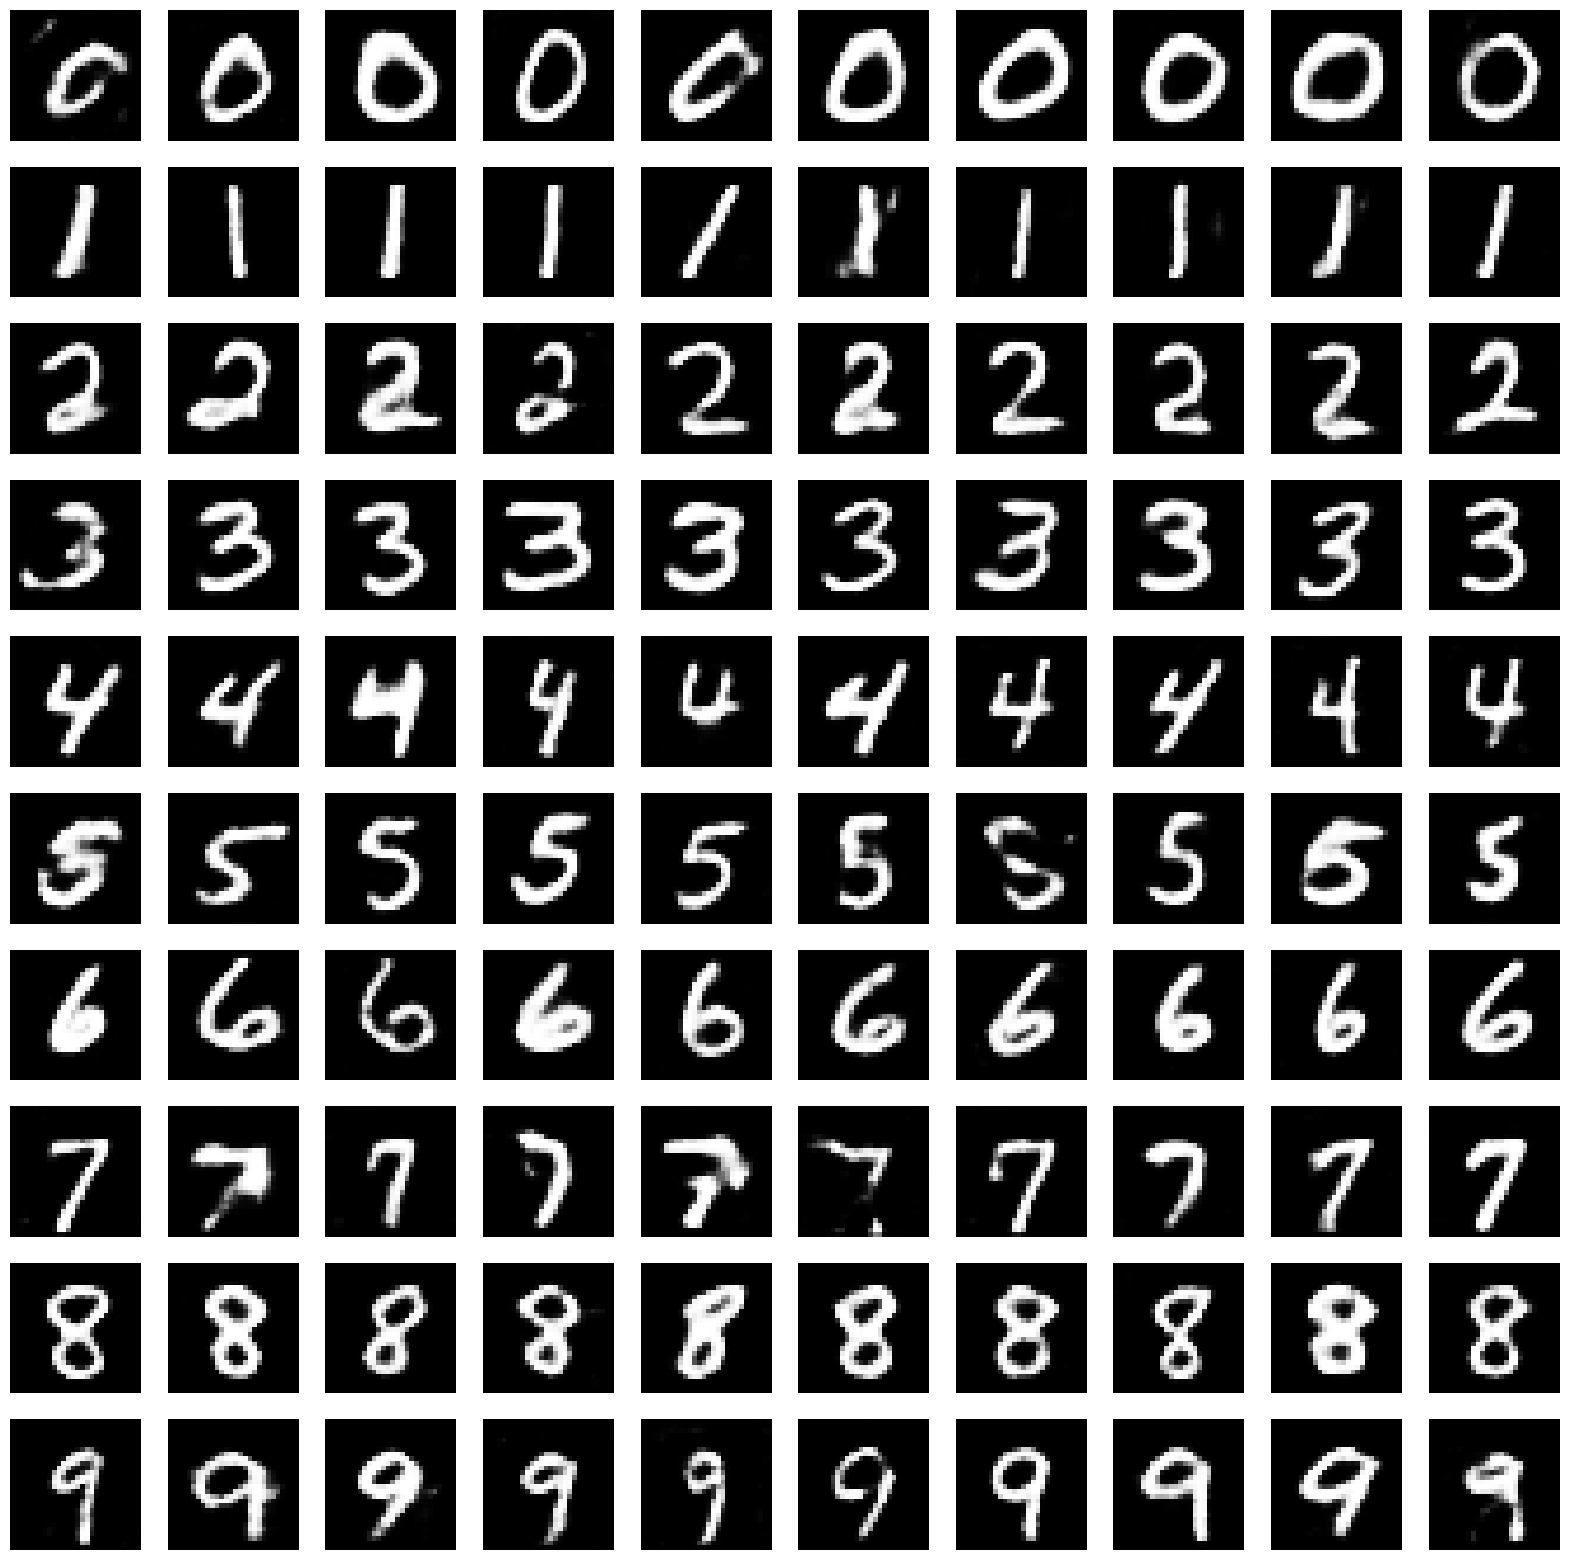

In [8]:
# Générer des images
generator.eval()

num_classes = 10
num_images_per_class = 10
labels = torch.arange(num_classes).repeat_interleave(num_images_per_class).to(device)
z = torch.randn(num_classes * num_images_per_class, generator.latent_dim).to(device)
images = generator.decode(z, labels)
images = images.view(-1, 28, 28).detach().cpu().numpy()

fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(20, 20))
for i in range(num_classes):
	for j in range(num_images_per_class):
		ax = axes[i, j]
		ax.imshow(images[i * num_images_per_class + j], cmap='gray')
		ax.axis('off')

plt.show()